<br>

<center><img src="https://www.htu.edu.jo/images/ThumbnailsCoverPhotos/HTU%20Logo-250px.png" alt="HTU"  width="180px" align="center">


<br>

<p>

**Modeling and Simulation**

10204330

Section (2)

**Application of Modeling and Simulation in Computational Neuroscience**

**Submitted to**

Dr. Murad Yaghi

**Submitted on**

June 15th, 2024

**Submitted by**

Marwan Tarek Shafiq Al Farah

**Student ID**

21110011

Spring 2023 – 2024
</p></center>

# **Importing Libraries**

In [1]:
pip install allensdk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 335.9/335.9 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 8.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 84.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from allensdk.core.cell_types_cache import CellTypesCache
import random
from scipy.interpolate import interp1d

# **Functions For Plotting the Membrane Potential and the Input Current**

In [2]:
def plot_potential(t, v, title):
  plt.plot(t, v)
  plt.title("FitzHugh-Nagumo Model " + title)
  plt.xlabel("Time (ms)")
  plt.ylabel("Membrane potential (mV)")
  plt.legend()
  plt.grid(True)
  plt.show()

In [3]:
def plot_current(t, i, title):
  plt.plot(t, i)
  plt.title("FitzHugh-Nagumo Model " + title)
  plt.xlabel("Time (ms)")
  plt.ylabel("Input Current (pA)")
  plt.legend()
  plt.grid(True)
  plt.show()

In [4]:
def plot_recovery(t, w, title):
  plt.plot(t, w)
  plt.title("FitzHugh-Nagumo Model " + title)
  plt.xlabel("Time (ms)")
  plt.ylabel("Reecovery Variable")
  plt.legend()
  plt.grid(True)
  plt.show()

# **Empirical Data**

In [5]:
ctc = CellTypesCache(manifest_file='cell_types/manifest.json')
cell_specimen_id = 464212183
data_set = ctc.get_ephys_data(cell_specimen_id)

2024-06-22 07:42:17,344 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/491202878
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/491202878


In [6]:
sweep_number = 30
sweep_data = data_set.get_sweep(sweep_number)

index_range = sweep_data["index_range"]
i = sweep_data["stimulus"][0:index_range[1]+1]
v = sweep_data["response"][0:index_range[1]+1]
i *= 1e12  # to pA
v *= 1e3  # to mV

sampling_rate = sweep_data["sampling_rate"]
t = np.arange(0, len(v)) * (1.0 / sampling_rate) * 1000

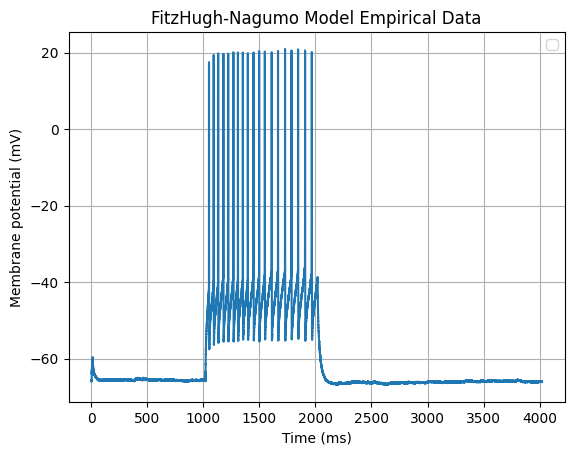

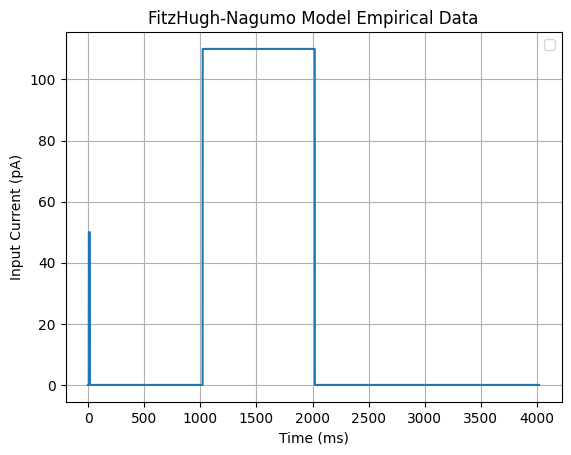

In [7]:
plot_potential(t, v, "Empirical Data")
plot_current(t, i, "Empirical Data")

In [8]:
mask = (t >= 1400) & (t <= 2000)
t = t[mask]
v = v[mask]
i = i[mask]
t = t - min(t)

In [9]:
downsample_indices = np.arange(0, len(v), 10)
v = v[downsample_indices]
t = t[downsample_indices]
i = i[downsample_indices]

In [10]:
v = 2 * (v - min(v)) / (max(v) - min(v)) - 1

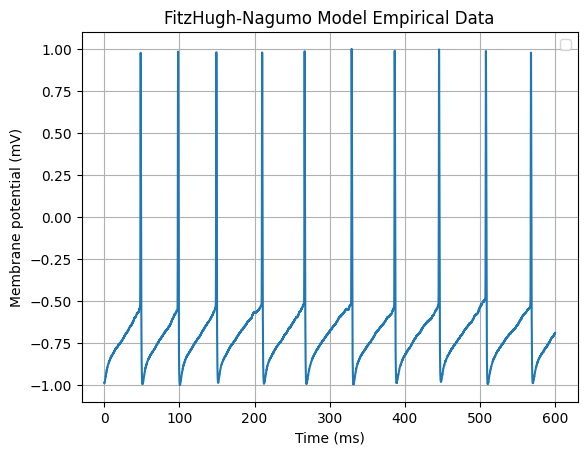

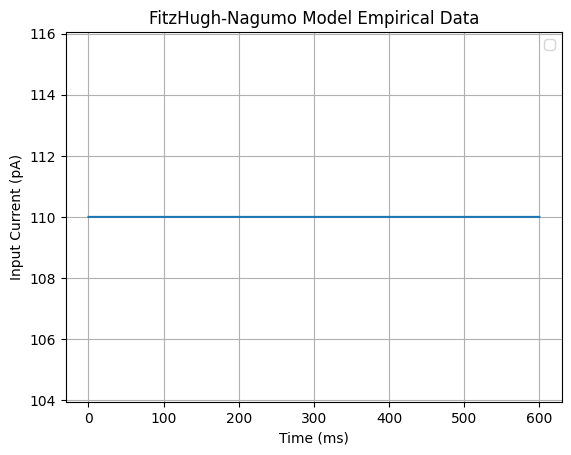

In [11]:
plot_potential(t, v, "Empirical Data")
plot_current(t, i, "Empirical Data")

# **FitzHugh–Nagumo model**

## **Model's Parameters and Initial Conditions**

In [93]:
a = 0.3
b = 0.9
epsilon = 0.07
I = 0.11
dt = 0.05
total_time = 600

In [84]:
v0 = -1
w0 = 1

## **First-Order System**

In [147]:
class FitzHughNagumo_V:
    def __init__(self, a, b, epsilon, I, dt, total_time, v0, w0):
        self.a = a
        self.b = b
        self.epsilon = epsilon
        self.I = I
        self.dt = dt
        self.total_time = total_time
        self.t = np.arange(0, total_time, dt)
        self.v = np.zeros_like(self.t)
        self.v[0] = v0
        self.w_const = w0

    def update(self):
        for i in range(1, len(self.t)):
            self.v[i] = self.v[i-1] + self.dt * (self.v[i-1] - self.v[i-1]**3 / 3 - self.w_const + self.I)
        self.v = 2 * (self.v - min(self.v)) / (max(self.v) - min(self.v)) - 1

In [207]:
class FitzHughNagumo_W:
    def __init__(self, a, b, epsilon, I, dt, total_time, v0, w0):
        self.a = a
        self.b = b
        self.epsilon = epsilon
        self.I = I
        self.dt = dt
        self.total_time = total_time
        self.t = np.arange(0, total_time, dt)
        self.w = np.zeros_like(self.t)
        self.w[0] = w0
        self.v_const = v0

    def update(self):
        for i in range(1, len(self.t)):
            self.w[i] = self.w[i-1] + self.dt * self.epsilon * (self.v_const + self.a - self.b * self.w[i-1])
        self.w = 2 * (self.w - min(self.w)) / (max(self.w) - min(self.w)) - 1

In [208]:
fhn_model_v = FitzHughNagumo_V(a, b, epsilon, I, dt, total_time, v0, w0)
fhn_model_v.update()

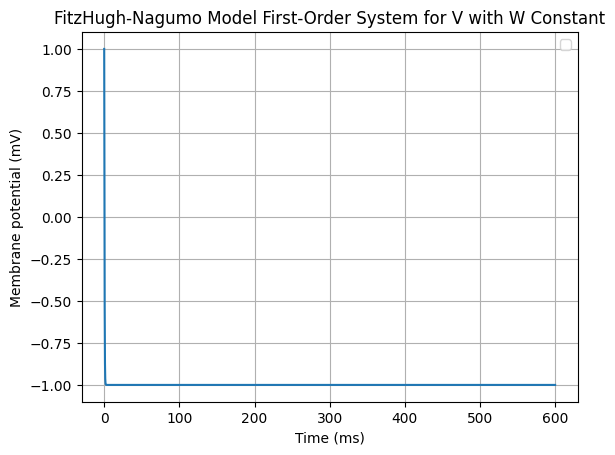

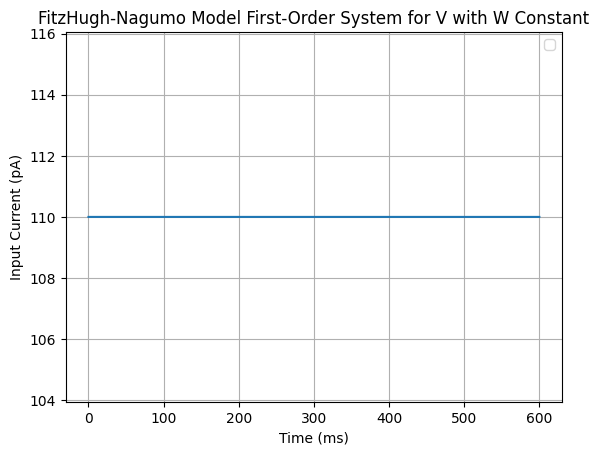

In [209]:
plot_potential(fhn_model_v.t, fhn_model_v.v, "First-Order System for V with W Constant")
plot_current(fhn_model_v.t, [fhn_model_v.I * 1e3] * len(fhn_model_v.t), "First-Order System for V with W Constant")

In [210]:
fhn_model_w = FitzHughNagumo_W(a, b, epsilon, I, dt, total_time, v0, w0)
fhn_model_w.update()

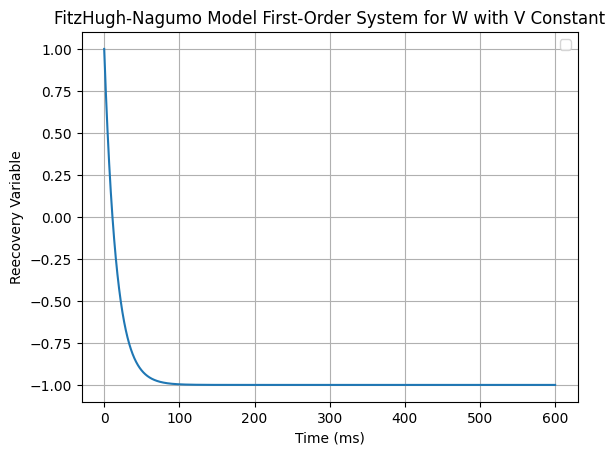

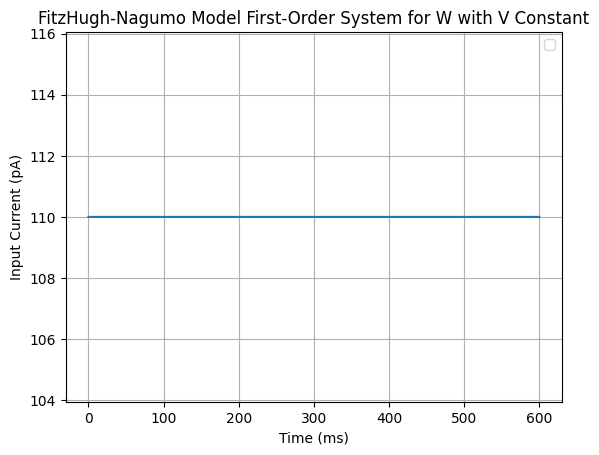

In [211]:
plot_recovery(fhn_model_w.t, fhn_model_w.w, "First-Order System for W with V Constant")
plot_current(fhn_model_w.t, [fhn_model_w.I * 1e3] * len(fhn_model_w.t), "First-Order System for W with V Constant")

## **Second-Order System**

In [86]:
class FitzHughNagumoSecondOrder:
    def __init__(self, a, b, epsilon, I_func, dt, total_time, v0, w0):
        self.a = a
        self.b = b
        self.epsilon = epsilon
        self.I_func = I_func
        self.dt = dt
        self.total_time = total_time
        self.t = np.arange(0, total_time, dt)
        self.v = np.zeros_like(self.t)
        self.w = np.zeros_like(self.t)
        self.v[0] = v0
        self.w[0] = w0

    def update(self):
        for i in range(1, len(self.t)):
            I = self.I_func(self.t[i-1])
            self.v[i] = self.v[i-1] + self.dt * (self.v[i-1] - self.v[i-1]**3 / 3 - self.w[i-1] + I)
            self.w[i] = self.w[i-1] + self.dt * self.epsilon * (self.v[i-1] + self.a - self.b * self.w[i-1])
        self.v = 2 * (self.v - min(self.v)) / (max(self.v) - min(self.v)) - 1

In [112]:
def I_func(t):
    return 0.11

In [113]:
fhn_model_second_order = FitzHughNagumoSecondOrder(a, b, epsilon, I_func, dt, total_time, v0, w0)
fhn_model_second_order.update()

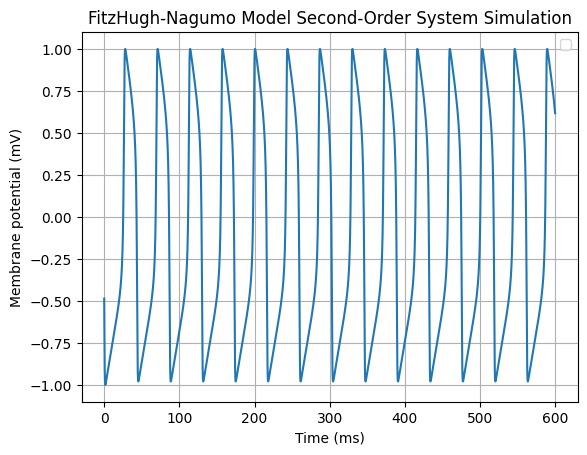

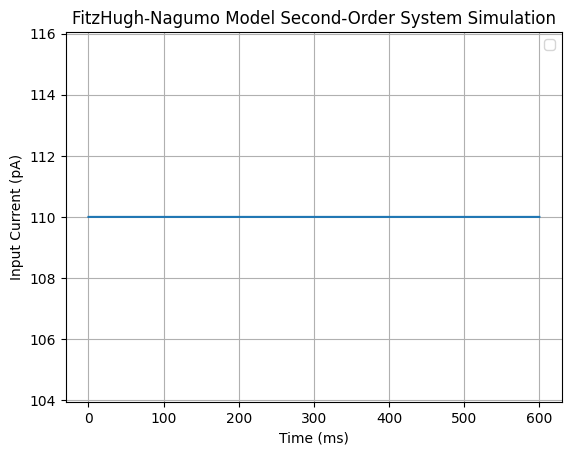

In [114]:
plot_potential(fhn_model_second_order.t, fhn_model_second_order.v, "Second-Order System Simulation")
plot_current(fhn_model_second_order.t, [fhn_model_second_order.I_func(i) * 1e3 for i in fhn_model_second_order.t], "Second-Order System Simulation")

## **Comparison between First-Order and Second-Order Simulations and the Empirical Data**

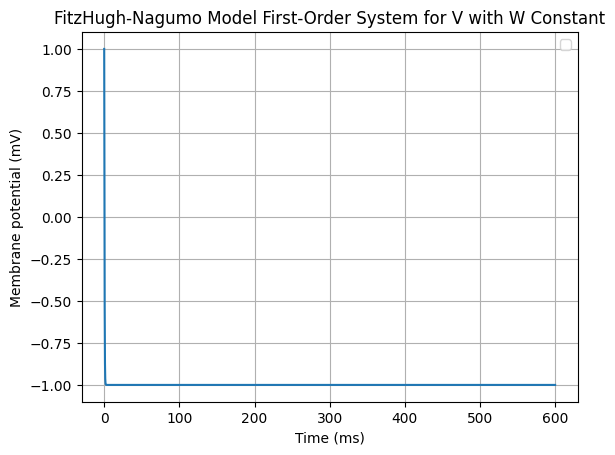

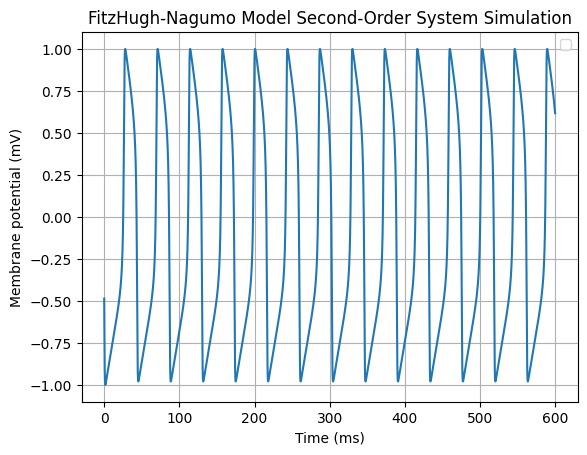

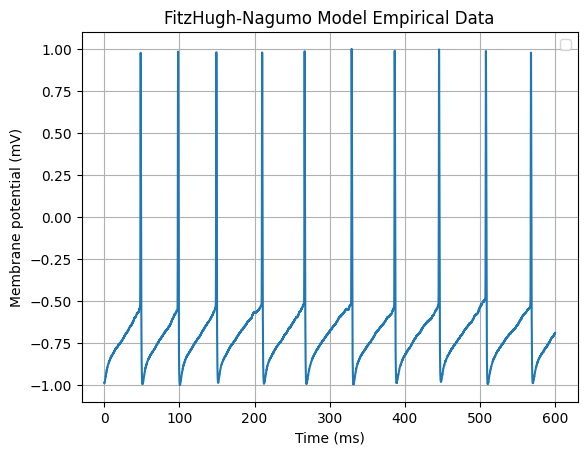

In [24]:
plot_potential(fhn_model_v.t, fhn_model_v.v, "First-Order System for V with W Constant")
plot_potential(fhn_model_second_order.t, fhn_model_second_order.v, "Second-Order System Simulation")
plot_potential(t, v, "Empirical Data")

In [25]:
def cost_function(v, predicted_v):
    mse = np.mean((v[:-1] - predicted_v) ** 2)
    return mse

In [26]:
print("MSE between First-Order System and Empirical Data:", cost_function(v, fhn_model_v.v))
print("MSE between Second-Order System and Empirical Data:", cost_function(v, fhn_model_second_order.v))

MSE between First-Order System and Empirical Data: 0.1352453840780461
MSE between Second-Order System and Empirical Data: 0.8841727848606492


## **Optimization**

In [ ]:
def cost_function(a, b, epsilon, observed_v, observed_t, I_func, dt, v0, w0):
    total_time = observed_t[-1] - observed_t[0]
    model = FitzHughNagumoSecondOrder(a, b, epsilon, I_func, dt, total_time, v0, w0)
    model.update()
    mse = np.mean((model.v - observed_v[:-1]) ** 2)
    return mse

### **Simulated Annealing**

In [ ]:
def simulated_annealing_fitzhugh(observed_v, observed_t, dt, v0, w0, I_func):
    a, b, epsilon = 0.3, 0.9, 0.07
    best_a, best_b, best_epsilon = a, b, epsilon
    best_cost = np.inf
    cost_history = []
    temp = 1.0
    temp_min = 0.00000001
    alpha = 0.999
    iter = 0

    while temp > temp_min:
        a_try, b_try, epsilon_try = a + np.random.uniform(-0.1, 0.1), b + np.random.uniform(-0.1, 0.1), epsilon + np.random.uniform(-0.01, 0.01)
        cost_current = cost_function(a, b, epsilon, observed_v, observed_t, I_func, dt, v0, w0)
        cost_try = cost_function(a_try, b_try, epsilon_try, observed_v, observed_t, I_func, dt, v0, w0)

        if cost_try < best_cost:
            best_cost = cost_try
            best_a, best_b, best_epsilon = a_try, b_try, epsilon_try

        if cost_try < cost_current or np.random.uniform() < np.exp((cost_current - cost_try) / temp):
            a, b, epsilon = a_try, b_try, epsilon_try

        cost_history.append(best_cost)
        temp *= alpha
        if iter == 0 or (iter + 1) % 100 == 0:
            print(f"Iteration {iter + 1}: Cost = {best_cost}: Temperature: {temp}")
        iter += 1
    return (best_a, best_b, best_epsilon), best_cost, cost_history

In [ ]:
best_params_sa, best_cost_sa, cost_history_sa = simulated_annealing_fitzhugh(v, t, dt, v0, w0, I_func)

Iteration 1: Cost = 0.8333981773691268: Temperature: 0.999
Iteration 100: Cost = 0.5145824150628869: Temperature: 0.9047921471137096
Iteration 200: Cost = 0.5145824150628869: Temperature: 0.818648829478636
Iteration 300: Cost = 0.5145824150628869: Temperature: 0.7407070321560997
Iteration 400: Cost = 0.4322698935281871: Temperature: 0.6701859060067403


<ipython-input-193-fadd028b8373>:18: RuntimeWarning: overflow encountered in double_scalars
  self.v[i] = self.v[i-1] + self.dt * (self.v[i-1] - self.v[i-1]**3 / 3 - self.w[i-1] + I)
<ipython-input-193-fadd028b8373>:18: RuntimeWarning: invalid value encountered in double_scalars
  self.v[i] = self.v[i-1] + self.dt * (self.v[i-1] - self.v[i-1]**3 / 3 - self.w[i-1] + I)
<ipython-input-193-fadd028b8373>:20: RuntimeWarning: invalid value encountered in subtract
  self.v = 2 * (self.v - min(self.v)) / (max(self.v) - min(self.v)) - 1
<ipython-input-193-fadd028b8373>:20: RuntimeWarning: invalid value encountered in divide
  self.v = 2 * (self.v - min(self.v)) / (max(self.v) - min(self.v)) - 1


Iteration 500: Cost = 0.0678574538641733: Temperature: 0.6063789448611848
Iteration 600: Cost = 0.0667242323651082: Temperature: 0.5486469074854965
Iteration 700: Cost = 0.05935996187935451: Temperature: 0.4964114134310989
Iteration 800: Cost = 0.049743742347740046: Temperature: 0.4491491486100748
Iteration 900: Cost = 0.049743742347740046: Temperature: 0.4063866225452039
Iteration 1000: Cost = 0.04488540717361331: Temperature: 0.3676954247709635
Iteration 1100: Cost = 0.04488540717361331: Temperature: 0.33268793286240766
Iteration 1200: Cost = 0.04488540717361331: Temperature: 0.3010134290933992
Iteration 1300: Cost = 0.04488540717361331: Temperature: 0.27235458681947705
Iteration 1400: Cost = 0.04488540717361331: Temperature: 0.24642429138466176
Iteration 1500: Cost = 0.04488540717361331: Temperature: 0.22296276370290227
Iteration 1600: Cost = 0.04488540717361331: Temperature: 0.20173495769715546
Iteration 1700: Cost = 0.04488540717361331: Temperature: 0.18252820552270246
Iteration 1

In [ ]:
print("Best Parameters:", best_params_sa)
print("Best Cost:", best_cost_sa)

Best Parameters: (8.130915592220816, 14.235885956326515, 0.009067361656806173)
Best Cost: 0.044443861096531916


In [ ]:
a_opt_sa, b_opt_sa, epsilon_opt_sa = best_params_sa
model_sa = FitzHughNagumoSecondOrder(a_opt_sa, b_opt_sa, epsilon_opt_sa, I_func, dt, total_time, v0, w0)
model_sa.update()

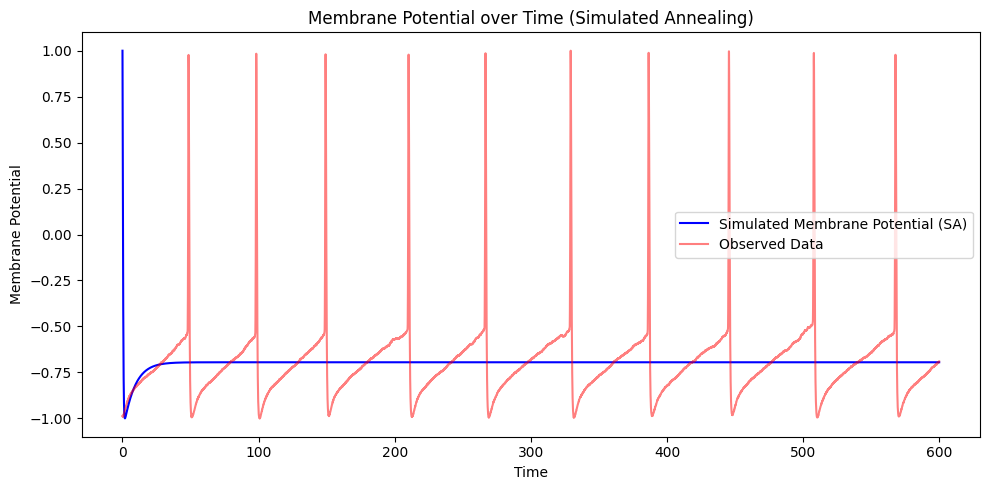

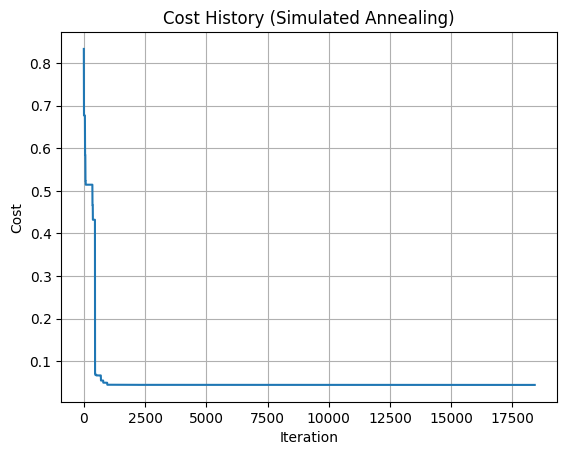

In [ ]:
time_points = np.linspace(t[0], t[-1], int((t[-1] - t[0]) / dt) + 1)
plt.figure(figsize=(10, 5))
plt.plot(time_points, model_sa.v, color='blue', label='Simulated Membrane Potential (SA)')
plt.plot(t, v, color='red', label='Observed Data', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Membrane Potential')
plt.title('Membrane Potential over Time (Simulated Annealing)')
plt.legend()
plt.tight_layout()
plt.show()

plt.plot(cost_history_sa)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost History (Simulated Annealing)')
plt.grid(True)
plt.show()

### **Gradient Descent**

In [ ]:
def numerical_gradient(a, b, epsilon, dt, observed_v, observed_t, v0, w0, I_func, current_cost, epsilon_step):
    grad = np.zeros(3)
    params = np.array([a, b, epsilon])
    for i in range(3):
        params_forward = params.copy()
        params_forward[i] += epsilon_step
        grad[i] = (cost_function(params_forward[0], params_forward[1], params_forward[2], observed_v, observed_t, I_func, dt, v0, w0) - current_cost) / epsilon_step
    return grad

In [ ]:
def gradient_descent_fitzhugh(observed_v, observed_t, dt, v0, w0, I_func, lr=0.01, epsilon_step=0.01, max_iter=1000):
    a, b, epsilon = 0.3, 0.9, 0.07
    best_params = (a, b, epsilon)
    best_cost = cost_function(a, b, epsilon, observed_v, observed_t, I_func, dt, v0, w0)
    cost_history = [best_cost]
    current_cost = best_cost
    for i in range(max_iter):
        gradients = numerical_gradient(a, b, epsilon, dt, observed_v, observed_t, v0, w0, I_func, current_cost, epsilon_step)
        grad_a, grad_b, grad_epsilon = gradients

        a -= lr * grad_a
        b -= lr * grad_b
        epsilon -= lr * grad_epsilon

        current_cost = cost_function(a, b, epsilon, observed_v, observed_t, I_func, dt, v0, w0)
        cost_history.append(current_cost)
        if current_cost < best_cost:
            best_cost = current_cost
            best_params = (a, b, epsilon)

        if i == 0 or (i + 1) % 100 == 0:
            print(f"Iteration {i + 1}: Cost = {current_cost}")

    return best_params, best_cost, cost_history

In [ ]:
best_params_gd, best_cost_gd, cost_history_gd = gradient_descent_fitzhugh(v, t, dt, v0, w0, I_func)

Iteration 1: Cost = 0.8738698142553678
Iteration 100: Cost = 0.14785655067593928
Iteration 200: Cost = 0.06307822952329456
Iteration 300: Cost = 0.05015244182692695
Iteration 400: Cost = 0.04665418203606176
Iteration 500: Cost = 0.04546671583289296
Iteration 600: Cost = 0.04501262527605131
Iteration 700: Cost = 0.044825678577525896
Iteration 800: Cost = 0.04474453248406466
Iteration 900: Cost = 0.04470772185323981
Iteration 1000: Cost = 0.04469030466022509


In [ ]:
print("Best Parameters (Gradient Descent):", best_params_gd)
print("Best Cost (Gradient Descent):", best_cost_gd)

Best Parameters (Gradient Descent): (1.8576940047999495, 1.3551336733738029, 0.789258915812943)
Best Cost (Gradient Descent): 0.04469030466022509


In [ ]:
a_opt_gd, b_opt_gd, epsilon_opt_gd = best_params_gd
model_gd = FitzHughNagumoSecondOrder(a_opt_gd, b_opt_gd, epsilon_opt_gd, I_func, dt, total_time, v0, w0)
model_gd.update()

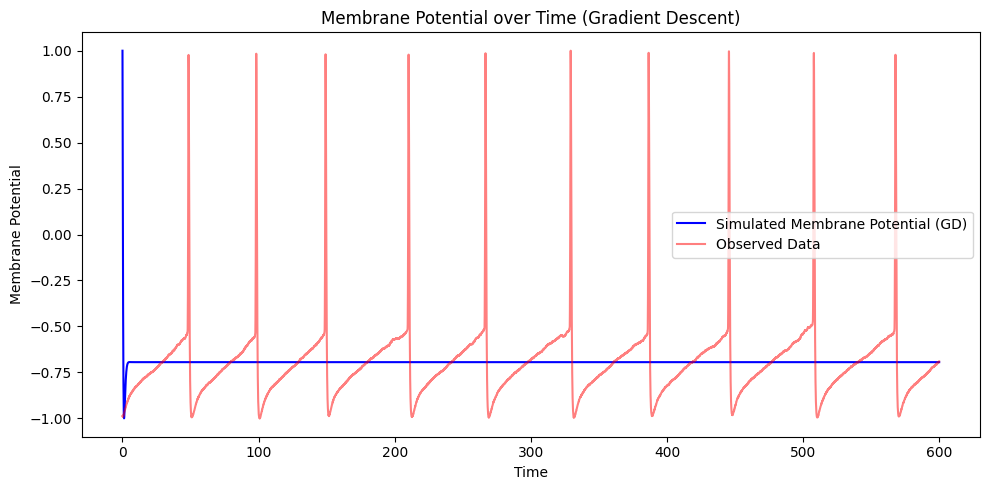

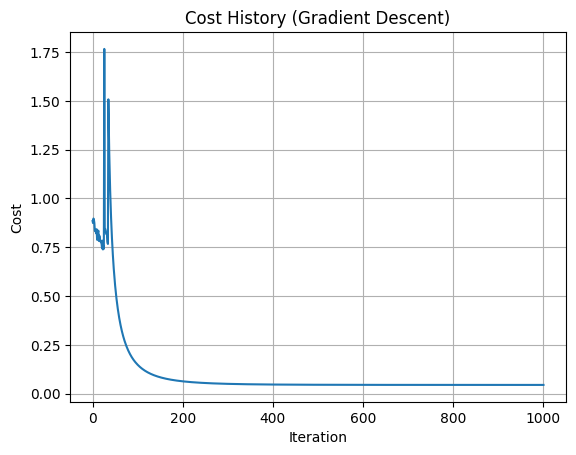

In [ ]:
time_points_gd = np.linspace(t[0], t[-1], int((t[-1] - t[0]) / dt) + 1)
plt.figure(figsize=(10, 5))
plt.plot(time_points_gd, model_gd.v, color='blue', label='Simulated Membrane Potential (GD)')
plt.plot(t, v, color='red', label='Observed Data', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Membrane Potential')
plt.title('Membrane Potential over Time (Gradient Descent)')
plt.legend()
plt.tight_layout()
plt.show()

plt.plot(cost_history_gd)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost History (Gradient Descent)')
plt.grid(True)
plt.show()

### **Genetic Algorithm**

In [ ]:
def fitness_function(a, b, epsilon, observed_v, observed_t, I_func, dt, v0, w0):
    mse = cost_function(a, b, epsilon, observed_v, observed_t, I_func, dt, v0, w0)
    return -mse

In [ ]:
def initialize_population(size, param_bounds):
    num_parameters = len(param_bounds)
    population = np.random.rand(size, num_parameters)
    for i in range(num_parameters):
        population[:, i] = param_bounds[i][0] + population[:, i] * (param_bounds[i][1] - param_bounds[i][0])
    return population

In [ ]:
def select_parents(population, fitness, num_parents):
    parents = population[np.argsort(fitness)[-num_parents:]]
    return parents

In [ ]:
def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    crossover_point = np.uint8(offspring_size[1] / 2)
    for k in range(offspring_size[0]):
        parent1_idx = k % parents.shape[0]
        parent2_idx = (k + 1) % parents.shape[0]
        offspring[k, :crossover_point] = parents[parent1_idx, :crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

In [ ]:
def mutate(offspring_crossover, param_bounds):
    mutations_strength = 0.001
    for idx in range(offspring_crossover.shape[0]):
        param_to_mutate = np.random.randint(0, offspring_crossover.shape[1])
        random_value = np.random.uniform(-mutations_strength, mutations_strength)
        offspring_crossover[idx, param_to_mutate] += random_value
        offspring_crossover[idx, param_to_mutate] = np.clip(offspring_crossover[idx, param_to_mutate], param_bounds[param_to_mutate][0], param_bounds[param_to_mutate][1])
    return offspring_crossover

In [ ]:
def genetic_algorithm_fitzhugh(observed_v, observed_t, I_func, dt, v0, w0, generations=1000, population_size=50, num_parents=25, param_bounds=[(0.1, 0.5), (0.5, 1.5), (0.01, 0.1)]):
    population = initialize_population(population_size, param_bounds)
    best_fitness_history = []

    for generation in range(generations):
        fitness = np.array([fitness_function(ind[0], ind[1], ind[2], observed_v, observed_t, I_func, dt, v0, w0) for ind in population])
        best_fitness_history.append(np.max(fitness))

        parents = select_parents(population, fitness, num_parents)
        offspring_crossover = crossover(parents, (population_size - parents.shape[0], 3))
        offspring_mutation = mutate(offspring_crossover, param_bounds)

        population[0:parents.shape[0], :] = parents
        population[parents.shape[0]:, :] = offspring_mutation

        if generation == 0 or (generation + 1) % 100 == 0:
          print(f"Generation {generation + 1}: Best Fitness = {best_fitness_history[-1]}")

    best_fit_idx = np.argmax(fitness)
    best_solution = population[best_fit_idx]
    return best_solution, best_fitness_history[-1], best_fitness_history

In [ ]:
best_params_ga, best_fitness_ga, fitness_history_ga = genetic_algorithm_fitzhugh(v, t, I_func, dt, v0, w0)

Generation 1: Best Fitness = -0.6769069980270763
Generation 100: Best Fitness = -0.5562887650483644
Generation 200: Best Fitness = -0.5488052573171476
Generation 300: Best Fitness = -0.5488052573171476
Generation 400: Best Fitness = -0.548797179833462
Generation 500: Best Fitness = -0.5484662730921167
Generation 600: Best Fitness = -0.5484662730921167
Generation 700: Best Fitness = -0.5484662730921167
Generation 800: Best Fitness = -0.5484662730921167
Generation 900: Best Fitness = -0.5484543728684191
Generation 1000: Best Fitness = -0.5484543728684191


In [ ]:
print("Best Parameters (Genetic Algorithm):", best_params_ga)
print("Best Fitness (Genetic Algorithm):", best_fitness_ga)

Best Parameters (Genetic Algorithm): [0.45040088 0.93583122 0.08327383]
Best Fitness (Genetic Algorithm): -0.5484543728684191


In [ ]:
a_opt_ga, b_opt_ga, epsilon_opt_ga = best_params_ga
model_ga = FitzHughNagumoSecondOrder(a_opt_ga, b_opt_ga, epsilon_opt_ga, I_func, dt, total_time, v0, w0)
model_ga.update()

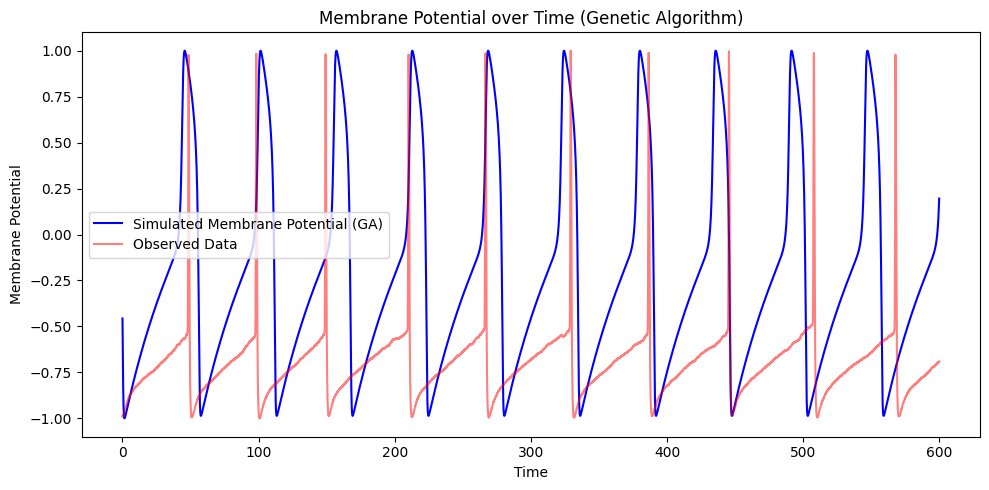

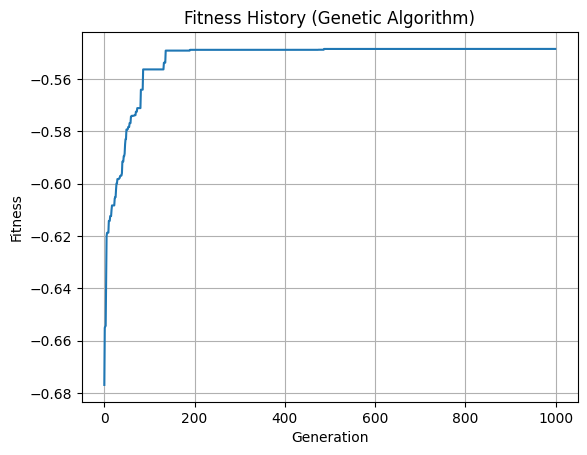

In [ ]:
time_points_ga = np.linspace(t[0], t[-1], int((t[-1] - t[0]) / dt) + 1)
plt.figure(figsize=(10, 5))
plt.plot(time_points_ga, model_ga.v, color='blue', label='Simulated Membrane Potential (GA)')
plt.plot(t, v, color='red', label='Observed Data', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Membrane Potential')
plt.title('Membrane Potential over Time (Genetic Algorithm)')
plt.legend()
plt.tight_layout()
plt.show()

plt.plot(fitness_history_ga)
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness History (Genetic Algorithm)')
plt.grid(True)
plt.show()

# **Leaky Integrate-and-Fire**

In [ ]:
class LeakyIntegrateAndFire:
    def __init__(self, R, C, V_th, V_reset, I, dt, total_time, V0):
        self.R = R  # Resistance in kOhm
        self.C = C  # Capacitance in uF
        self.V_th = V_th  # Threshold voltage in mV
        self.V_reset = V_reset  # Reset voltage in mV
        self.I = I  # Input current in nA
        self.dt = dt  # Time step in ms
        self.total_time = total_time  # Total simulation time
        self.t = np.arange(0, total_time, dt)  # Time vector
        self.V = np.zeros_like(self.t)  # Membrane potential vector
        self.V[0] = V0  # Initial membrane potential

    def update(self):
        for i in range(1, len(self.t)):
            dV = (self.dt / self.C) * (self.I - (self.V[i-1] / self.R))
            self.V[i] = self.V[i-1] + dV
            if self.V[i] >= self.V_th:
                self.V[i] = self.V_reset

In [ ]:
# Parameters for the LIF model
R = 20  # Resistance in kOhm
C = 3  # Capacitance in uF
V_th = 1  # Threshold voltage in mV
V_reset = -1  # Reset voltage in mV
I = 0.11 # Input current in nA
dt = 0.05  # Time step in ms
total_time = 600  # Total time in ms
V0 = -1 # Initial membrane potential in mV

In [ ]:
# Instantiate and run the LIF model
lif_model = LeakyIntegrateAndFire(R, C, V_th, V_reset, I, dt, total_time, V0)
lif_model.update()

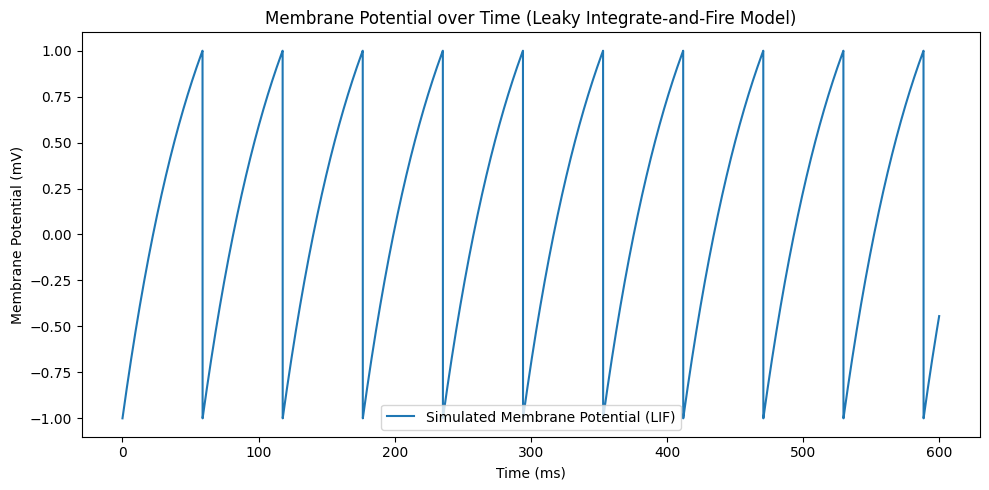

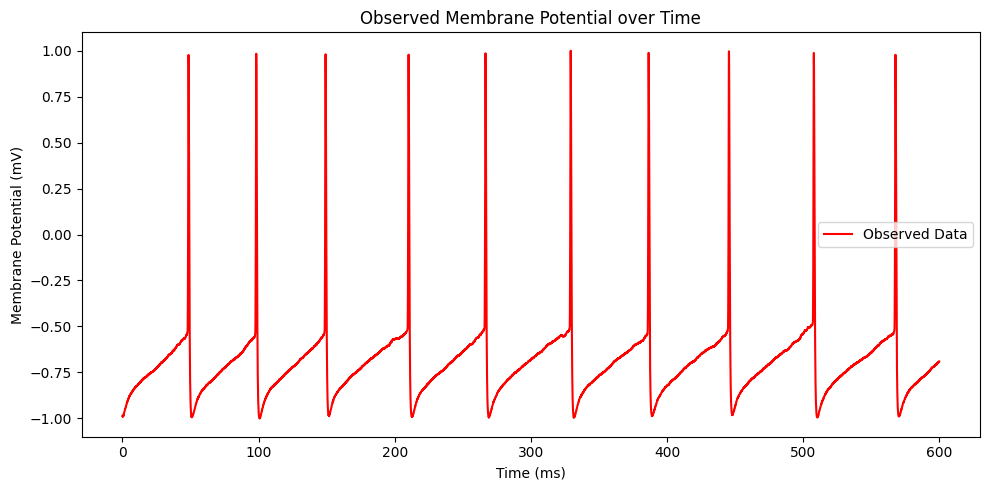

In [ ]:
# Plot the membrane potential over time for the LIF model
plt.figure(figsize=(10, 5))
plt.plot(np.array(lif_model.t, dtype="float32"), np.array(lif_model.V, dtype="float32"), label='Simulated Membrane Potential (LIF)')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Membrane Potential over Time (Leaky Integrate-and-Fire Model)')
plt.legend()
plt.tight_layout()
plt.show()

# Plot the observed data for comparison
plt.figure(figsize=(10, 5))
plt.plot(t, v, label='Observed Data', color='red')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Observed Membrane Potential over Time')
plt.legend()
plt.tight_layout()
plt.show()

## **Optimization**

In [ ]:
def cost_function(observed_v, observed_t, R, C, V_th, V_reset, I, dt, V0):
    total_time = observed_t[-1] - observed_t[0]
    model = LeakyIntegrateAndFire(R, C, V_th, V_reset, I, dt, total_time, V0)
    model.update()
    mse = np.mean((model.V - observed_v[:-1]) ** 2)
    return mse

### **Simulated Annealing**

In [ ]:
def simulated_annealing_lif(observed_v, observed_t, V_th, V_reset, I, dt, V0):
    R, C = 20, 3
    best_R, best_C = R, C
    best_cost = np.inf
    cost_history = []
    temp = 1.0
    temp_min = 0.00000001
    alpha = 0.999
    iter = 0

    while temp > temp_min:
        R_try, C_try = R + np.random.uniform(-0.1, 0.1), C + np.random.uniform(-0.1, 0.1)
        cost_current = cost_function(observed_v, observed_t, R, C, V_th, V_reset, I, dt, V0)
        cost_try = cost_function(observed_v, observed_t, R, C, V_th, V_reset, I, dt, V0)

        if cost_try < best_cost:
            best_cost = cost_try
            best_R, best_C = R_try, C_try

        if cost_try < cost_current or np.random.uniform() < np.exp((cost_current - cost_try) / temp):
            R, C = R_try, C_try

        cost_history.append(best_cost)
        temp *= alpha
        if iter == 0 or (iter + 1) % 100 == 0:
            print(f"Iteration {iter + 1}: Cost = {best_cost}: Temperature: {temp}")
        iter += 1
    return (best_R, best_C), best_cost, cost_history

In [ ]:
best_params_sa, best_cost_sa, cost_history_sa = simulated_annealing_lif(v, t, V_th, V_reset, I, dt, V0)

Iteration 1: Cost = 1.1175560710961752: Temperature: 0.999
Iteration 100: Cost = 1.0235186653740944: Temperature: 0.9047921471137096
Iteration 200: Cost = 1.0208268931039626: Temperature: 0.818648829478636
Iteration 300: Cost = 1.0208268931039626: Temperature: 0.7407070321560997
Iteration 400: Cost = 1.0208268931039626: Temperature: 0.6701859060067403
Iteration 500: Cost = 1.0208268931039626: Temperature: 0.6063789448611848
Iteration 600: Cost = 1.0208268931039626: Temperature: 0.5486469074854965
Iteration 700: Cost = 1.0208268931039626: Temperature: 0.4964114134310989
Iteration 800: Cost = 1.0208268931039626: Temperature: 0.4491491486100748
Iteration 900: Cost = 1.0208268931039626: Temperature: 0.4063866225452039
Iteration 1000: Cost = 1.0208268931039626: Temperature: 0.3676954247709635
Iteration 1100: Cost = 1.0208268931039626: Temperature: 0.33268793286240766
Iteration 1200: Cost = 1.0208268931039626: Temperature: 0.3010134290933992
Iteration 1300: Cost = 1.0208268931039626: Tempera

<ipython-input-32-900d0b2bd60d>:20: RuntimeWarning: overflow encountered in double_scalars
  self.V[i] = self.V[i-1] + dV
<ipython-input-42-49720ec9f1dd>:5: RuntimeWarning: overflow encountered in square
  mse = np.mean((model.V - observed_v[:-1]) ** 2)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
<ipython-input-43-0e60e14b95fc>:20: RuntimeWarning: invalid value encountered in double_scalars
  if cost_try < cost_current or np.random.uniform() < np.exp((cost_current - cost_try) / temp):


Iteration 4100: Cost = 0.9957240182505365: Temperature: 0.016538713596848224
Iteration 4200: Cost = 0.9957240182505365: Temperature: 0.014964098185791003
Iteration 4300: Cost = 0.9957240182505365: Temperature: 0.013539398527142203
Iteration 4400: Cost = 0.9957240182505365: Temperature: 0.012250341464001188
Iteration 4500: Cost = 0.9957240182505365: Temperature: 0.011084012756089733
Iteration 4600: Cost = 0.9957240182505365: Temperature: 0.010028727700218176
Iteration 4700: Cost = 0.9957240182505365: Temperature: 0.009073914068699134
Iteration 4800: Cost = 0.9957240182505365: Temperature: 0.008210006192943578
Iteration 4900: Cost = 0.9957240182505365: Temperature: 0.007428349131130266
Iteration 5000: Cost = 0.9957240182505365: Temperature: 0.006721111959865607
Iteration 5100: Cost = 0.9957240182505365: Temperature: 0.00608120932115843
Iteration 5200: Cost = 0.9957240182505365: Temperature: 0.00550223043873884
Iteration 5300: Cost = 0.9957240182505365: Temperature: 0.004978374892580918
I

In [ ]:
print("Best Parameters:", best_params_sa)
print("Best Cost:", best_cost_sa)

Best Parameters: (22.04113826216539, 2.8578598455024338)
Best Cost: 0.9957240182505365


In [ ]:
R_opt_sa, C_opt_sa = best_params_sa
model_sa = LeakyIntegrateAndFire(R, C, V_th, V_reset, I, dt, total_time, V0)
model_sa.update()

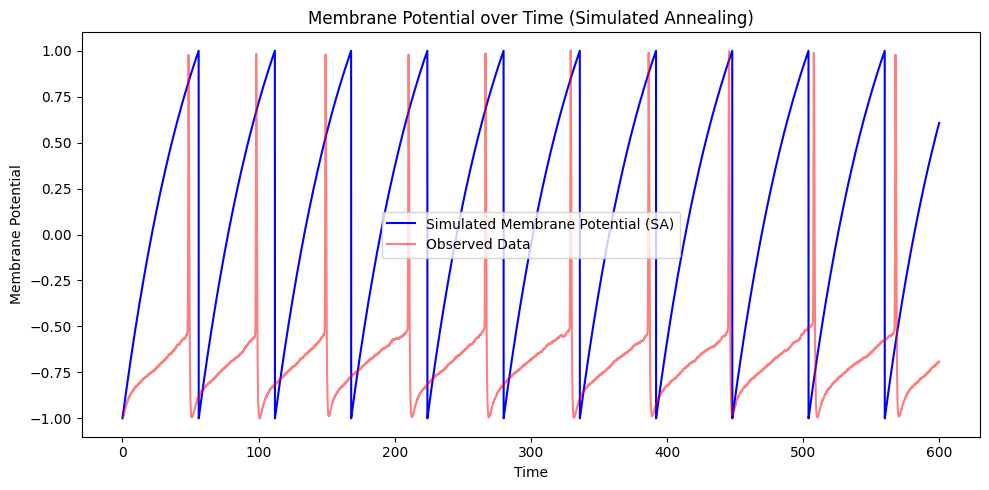

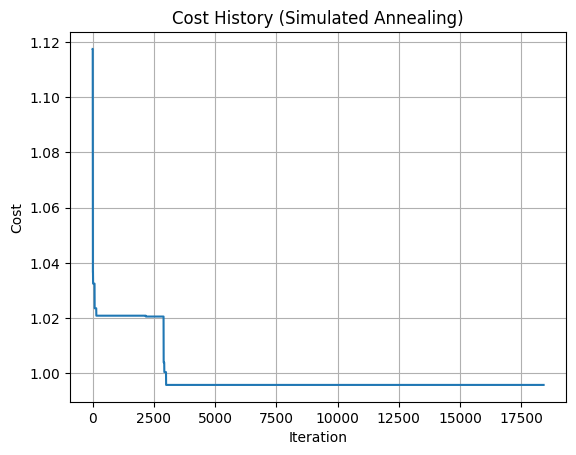

In [ ]:
time_points = np.linspace(t[0], t[-1], int((t[-1] - t[0]) / dt) + 1)
plt.figure(figsize=(10, 5))
plt.plot(time_points, model_sa.V, color='blue', label='Simulated Membrane Potential (SA)')
plt.plot(t, v, color='red', label='Observed Data', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Membrane Potential')
plt.title('Membrane Potential over Time (Simulated Annealing)')
plt.legend()
plt.tight_layout()
plt.show()

plt.plot(cost_history_sa)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost History (Simulated Annealing)')
plt.grid(True)
plt.show()

### **Gradient Descent**

In [ ]:
def numerical_gradient(observed_v, observed_t, R, C, V_th, V_reset, I, dt, V0, current_cost, epsilon_step):
    grad = np.zeros(2)
    params = np.array([R, C])
    for i in range(2):
        params_forward = params.copy()
        params_forward[i] += epsilon_step
        grad[i] = (cost_function(observed_v, observed_t, params_forward[0], params_forward[1], V_th, V_reset, I, dt, V0) - current_cost) / epsilon_step
    return grad

In [ ]:
def gradient_descent_lif(observed_v, observed_t, V_th, V_reset, I, dt, V0, lr=0.01, epsilon_step=0.05, max_iter=1000):
    R, C = 20, 3
    best_params = (R, C)
    best_cost = cost_function(observed_v, observed_t, R, C, V_th, V_reset, I, dt, V0)
    cost_history = [best_cost]
    current_cost = best_cost
    for i in range(max_iter):
        gradients = numerical_gradient(observed_v, observed_t, R, C, V_th, V_reset, I, dt, V0, current_cost, epsilon_step)
        grad_R, grad_C = gradients

        R -= lr * grad_R
        C -= lr * grad_C

        current_cost = cost_function(observed_v, observed_t, R, C, V_th, V_reset, I, dt, V0)
        cost_history.append(current_cost)
        if current_cost < best_cost:
            best_cost = current_cost
            best_params = (R, C)

        if i == 0 or (i + 1) % 100 == 0:
            print(f"Iteration {i + 1}: Cost = {current_cost}")

    return best_params, best_cost, cost_history

In [ ]:
best_params_gd, best_cost_gd, cost_history_gd = gradient_descent_lif(v, t, V_th, V_reset, I, dt, V0)

Iteration 1: Cost = 1.1175560710961752
Iteration 100: Cost = 1.026952661541028
Iteration 200: Cost = 1.0260732537971127
Iteration 300: Cost = 1.0255473715969659
Iteration 400: Cost = 1.0253643759112923
Iteration 500: Cost = 1.0244610987330498
Iteration 600: Cost = 1.0238828624115262
Iteration 700: Cost = 1.0236182685559718
Iteration 800: Cost = 1.023162761030838
Iteration 900: Cost = 1.0224799442846944
Iteration 1000: Cost = 1.022096268903421


In [ ]:
print("Best Parameters (Gradient Descent):", best_params_gd)
print("Best Cost (Gradient Descent):", best_cost_gd)

Best Parameters (Gradient Descent): (20.36601588486352, 2.863189842551749)
Best Cost (Gradient Descent): 1.0218633992673838


In [ ]:
R, C = best_params_gd
model_gd = LeakyIntegrateAndFire(R, C, V_th, V_reset, I, dt, total_time, V0)
model_gd.update()

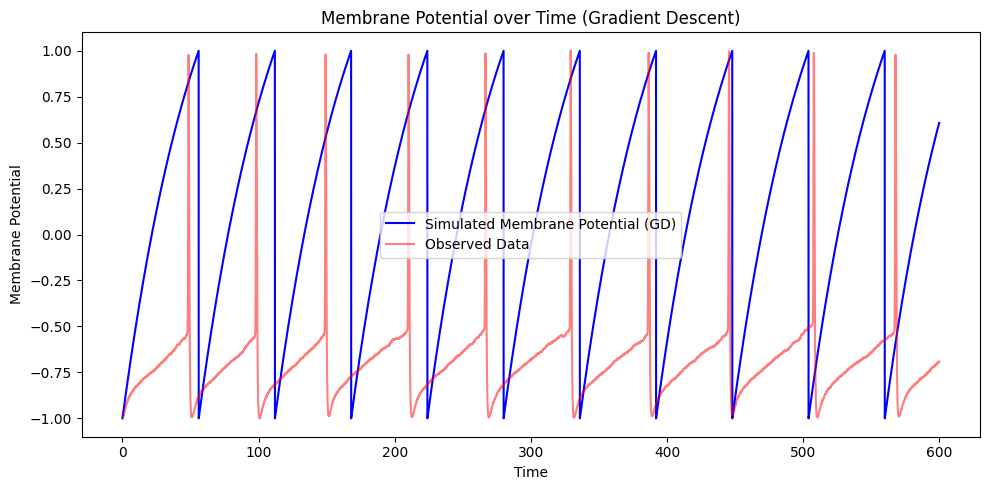

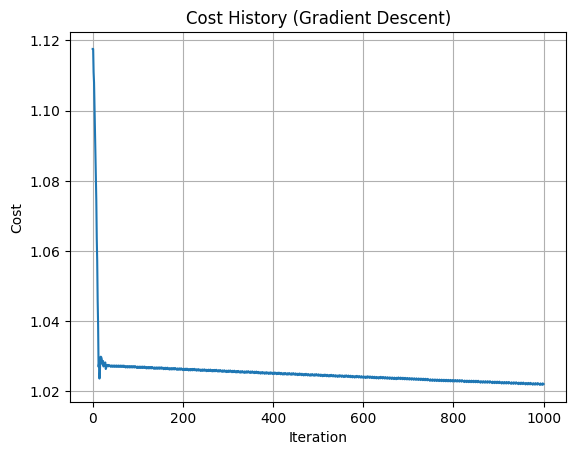

In [ ]:
time_points_gd = np.linspace(t[0], t[-1], int((t[-1] - t[0]) / dt) + 1)
plt.figure(figsize=(10, 5))
plt.plot(time_points_gd, model_gd.V, color='blue', label='Simulated Membrane Potential (GD)')
plt.plot(t, v, color='red', label='Observed Data', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Membrane Potential')
plt.title('Membrane Potential over Time (Gradient Descent)')
plt.legend()
plt.tight_layout()
plt.show()

plt.plot(cost_history_gd)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost History (Gradient Descent)')
plt.grid(True)
plt.show()

### **Genetic Algorithm**

In [ ]:
def fitness_function(observed_v, observed_t, R, C, V_th, V_reset, I, dt, V0):
    mse = cost_function(observed_v, observed_t, R, C, V_th, V_reset, I, dt, V0)
    return -mse

In [ ]:
def initialize_population(size, param_bounds):
    num_parameters = len(param_bounds)
    population = np.random.rand(size, num_parameters)
    for i in range(num_parameters):
        population[:, i] = param_bounds[i][0] + population[:, i] * (param_bounds[i][1] - param_bounds[i][0])
    return population

In [ ]:
def select_parents(population, fitness, num_parents):
    parents = population[np.argsort(fitness)[-num_parents:]]
    return parents

In [ ]:
def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    crossover_point = np.uint8(offspring_size[1] / 2)
    for k in range(offspring_size[0]):
        parent1_idx = k % parents.shape[0]
        parent2_idx = (k + 1) % parents.shape[0]
        offspring[k, :crossover_point] = parents[parent1_idx, :crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

In [ ]:
def mutate(offspring_crossover, param_bounds):
    mutations_strength = 0.1
    for idx in range(offspring_crossover.shape[0]):
        param_to_mutate = np.random.randint(0, offspring_crossover.shape[1])
        random_value = np.random.uniform(-mutations_strength, mutations_strength)
        offspring_crossover[idx, param_to_mutate] += random_value
        offspring_crossover[idx, param_to_mutate] = np.clip(offspring_crossover[idx, param_to_mutate], param_bounds[param_to_mutate][0], param_bounds[param_to_mutate][1])
    return offspring_crossover

In [ ]:
def genetic_algorithm_lif(observed_v, observed_t, V_th, V_reset, I, dt, V0, generations=1000, population_size=50, num_parents=25, param_bounds=[(0.001, 5000), (0.001, 5000)]):
    population = initialize_population(population_size, param_bounds)
    best_fitness_history = []

    for generation in range(generations):
        fitness = np.array([fitness_function(observed_v, observed_t, ind[0], ind[1], V_th, V_reset, I, dt, V0) for ind in population])
        best_fitness_history.append(np.max(fitness))

        parents = select_parents(population, fitness, num_parents)
        offspring_crossover = crossover(parents, (population_size - parents.shape[0], 2))
        offspring_mutation = mutate(offspring_crossover, param_bounds)

        population[0:parents.shape[0], :] = parents
        population[parents.shape[0]:, :] = offspring_mutation

        if generation == 0 or (generation + 1) % 100 == 0:
            print(f"Generation {generation + 1}: Best Fitness = {best_fitness_history[-1]}")

    best_fit_idx = np.argmax(fitness)
    best_solution = population[best_fit_idx]
    return best_solution, best_fitness_history[-1], best_fitness_history

In [ ]:
best_params_ga, best_fitness_ga, fitness_history_ga = genetic_algorithm_lif(v, t, V_th, V_reset, I, dt, V0)

Generation 1: Best Fitness = -0.07280242827157887
Generation 100: Best Fitness = -0.07090752947706622
Generation 200: Best Fitness = -0.06921752311245069
Generation 300: Best Fitness = -0.06784416206039141
Generation 400: Best Fitness = -0.0666509877164802
Generation 500: Best Fitness = -0.06575276066810913
Generation 600: Best Fitness = -0.06504588307333665
Generation 700: Best Fitness = -0.06446845942064178
Generation 800: Best Fitness = -0.0640477262999655
Generation 900: Best Fitness = -0.06372928681832433
Generation 1000: Best Fitness = -0.06354060097814238


In [ ]:
print("Best Parameters (Genetic Algorithm):", best_params_ga)
print("Best Fitness (Genetic Algorithm):", best_fitness_ga)

Best Parameters (Genetic Algorithm): [4228.82910127  138.21175471]
Best Fitness (Genetic Algorithm): -0.06354060097814238


In [ ]:
R_opt_ga, C_opt_ga = best_params_ga
model_ga = LeakyIntegrateAndFire(R, C, V_th, V_reset, I, dt, total_time, V0)
model_ga.update()

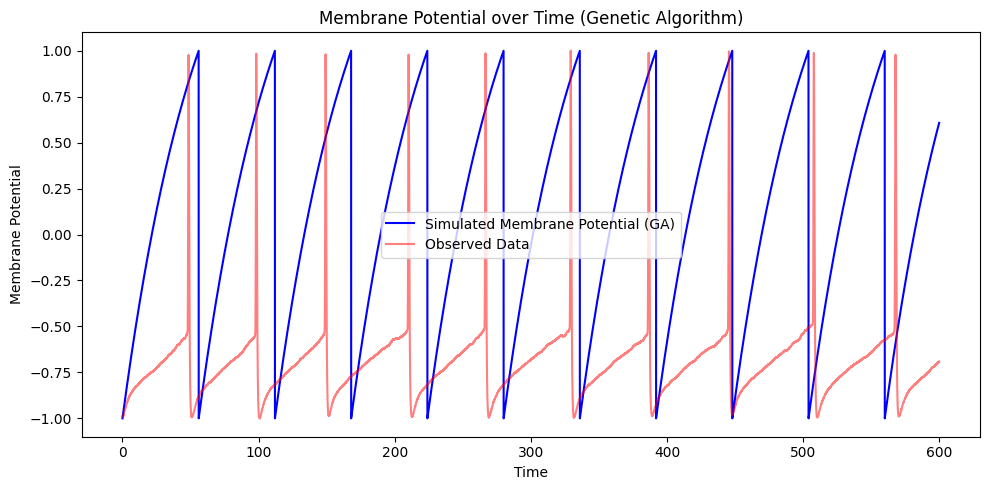

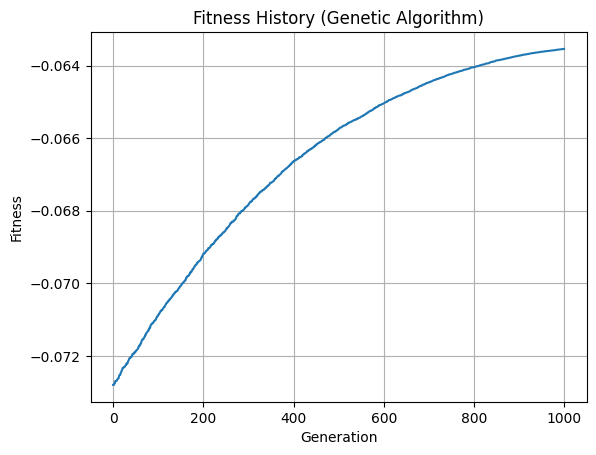

In [ ]:
time_points_ga = np.linspace(t[0], t[-1], int((t[-1] - t[0]) / dt) + 1)
plt.figure(figsize=(10, 5))
plt.plot(time_points_ga, model_ga.V, color='blue', label='Simulated Membrane Potential (GA)')
plt.plot(t, v, color='red', label='Observed Data', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Membrane Potential')
plt.title('Membrane Potential over Time (Genetic Algorithm)')
plt.legend()
plt.tight_layout()
plt.show()

plt.plot(fitness_history_ga)
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness History (Genetic Algorithm)')
plt.grid(True)
plt.show()